In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import torch
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display
import sympy as sp
import time
from datetime import datetime
sp.init_printing(use_latex=True)

In [26]:
BUCKET_NAME = "haodeep"
BATCH_SIZE = os.environ.get("BATCH_SIZE", 50)
NUM_WORKERS = os.environ.get("NUM_WORKERS", 2)
N = os.environ.get("SIZE", 2000)
VAL_SPLIT = os.environ.get("VAL_SPLIT", 0.2)
MAX_EPOCHS = os.environ.get("MAX_EPOCHS", 100)

In [27]:
import os
import numpy as np
import pandas as pd
import torch
import pytorch_lightning as pl
from PIL import Image
from io import BytesIO
import boto3
from torch.utils.data import Dataset

class S3ImageDataset(Dataset):
    def __init__(self, s3_bucket, s3_prefix, labels=None, img_size=(512, 512), transform=None):
        self.s3 = boto3.client('s3')
        self.bucket = s3_bucket
        self.prefix = s3_prefix
        self.img_size = img_size
        self.transform = transform
        self.labels = labels
        
        # List all files in the S3 prefix
        response = self.s3.list_objects_v2(Bucket=self.bucket, Prefix=self.prefix)
        self.file_keys = [item['Key'] for item in response.get('Contents', []) 
                         if item['Key'].lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    def __len__(self):
        return len(self.file_keys)
    
    def __getitem__(self, idx):
        key = self.file_keys[idx]
        
        # Get image from S3
        response = self.s3.get_object(Bucket=self.bucket, Key=key)
        img_bytes = response['Body'].read()
        
        # Load image
        img = Image.open(BytesIO(img_bytes)).convert('RGB').resize(self.img_size)
        img_array = np.array(img).astype('float32')
        img_tensor = torch.from_numpy(img_array).permute(2, 0, 1)  # CHW format
        
        # Get label if available
        if self.labels is not None:
            # Extract filename from S3 key
            filename = os.path.basename(key)
            label = self.labels.get(filename, 0)  # Default to 0 if not found
            return img_tensor, torch.tensor(label, dtype=torch.long)
        
        return img_tensor

class DataModule(pl.LightningDataModule):
    def __init__(self,
                 s3_bucket=BUCKET_NAME,
                 train_prefix='PALM-Training400/',
                 val_prefix='PALM-Validation400/',
                 val_label_key='PM_Label_and_Fovea_Location.xlsx',
                 img_size=(512, 512),
                 batch_size=BATCH_SIZE,
                 num_workers=NUM_WORKERS,
                 **kwargs):
        super().__init__(**kwargs)
        self.s3_bucket = s3_bucket
        self.train_prefix = train_prefix
        self.val_prefix = val_prefix
        self.val_label_key = val_label_key
        self.img_size = img_size
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
        self.s3 = boto3.client('s3')
        
    def _load_val_labels(self):
        # Load validation labels from S3
        obj = self.s3.get_object(Bucket=self.s3_bucket, Key=self.val_label_key)
        df = pd.read_excel(BytesIO(obj['Body'].read()))
        return dict(zip(df['imgName'], df['Label'].astype(int)))
    
    def _get_train_labels(self, s3_keys):
        labels = {}
        for key in s3_keys:
            filename = os.path.basename(key)
            label = 0 if filename[0] in ['H', 'N'] else 1 if filename[0] == 'P' else 0
            labels[filename] = label
        return labels
    
    def setup(self, stage=None):
        if stage in ('fit', None) and self.train_dataset is None:
            # For training data
            response = self.s3.list_objects_v2(Bucket=self.s3_bucket, Prefix=self.train_prefix)
            train_keys = [item['Key'] for item in response.get('Contents', []) 
                         if item['Key'].lower().endswith(('.png', '.jpg', '.jpeg'))]
            train_labels = self._get_train_labels(train_keys)
            self.train_dataset = S3ImageDataset(
                self.s3_bucket, self.train_prefix, train_labels, self.img_size)
            
        if stage in ('fit', 'validate', 'test', None) and self.val_dataset is None:
            # For validation data
            val_labels = self._load_val_labels()
            self.val_dataset = S3ImageDataset(
                self.s3_bucket, self.val_prefix, val_labels, self.img_size)
            self.test_dataset = self.val_dataset
    
    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=True
        )
    
    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False
        )
    
    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False
        )
    
    def predict_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers=self.num_workers,
            shuffle=False
        )

In [9]:
data_module = DataModule()

In [10]:
data_module.setup('fit')

In [12]:
dl = data_module.val_dataloader()
batch = next(iter(dl))

In [13]:
batch[0].shape

torch.Size([50, 3, 512, 512])

In [14]:
batch[1].shape

torch.Size([50])

In [15]:
class SinePositionEmbedding(pl.LightningModule):
    def __init__(self,
                 max_wavelength=10000.0,
                 **kwargs):
        super().__init__(**kwargs)
        self.max_wavelength = torch.Tensor([max_wavelength])

    def forward(self, x):
        input_shape = x.shape
        seq_length = x.shape[-2]
        hidden_size = x.shape[-1]
        position = torch.arange(seq_length).type_as(x)
        min_freq = (1 / self.max_wavelength).type_as(x)
        timescales = torch.pow(
            min_freq,
            (2 * (torch.arange(hidden_size) // 2)).type_as(x)
            / torch.Tensor([hidden_size]).type_as(x)
        )
        angles = torch.unsqueeze(position, 1) * torch.unsqueeze(timescales, 0)
        cos_mask = (torch.arange(hidden_size) % 2).type_as(x)
        sin_mask = 1 - cos_mask
        positional_encodings = (
            torch.sin(angles) * sin_mask + torch.cos(angles) * cos_mask
        )
        return torch.broadcast_to(positional_encodings, input_shape)

In [16]:
class TransformerBlock(pl.LightningModule):
    def __init__(self,
                 latent_size = 64,
                 num_heads = 4,
                 dropout = 0.1,
                 **kwargs):
        super().__init__(**kwargs)
        self.layer_norm1 = torch.nn.LayerNorm(latent_size)
        self.layer_norm2 = torch.nn.LayerNorm(latent_size)
        self.dropout = torch.nn.Dropout(dropout)
        self.activation = torch.nn.GELU()
        self.linear = torch.nn.Linear(latent_size,
                                      latent_size)
        self.mha = torch.nn.MultiheadAttention(latent_size,
                                               num_heads,
                                               dropout=dropout,
                                               batch_first=True)
    def forward(self, x):
        y = x
        y = self.layer_norm1(y)
        y = self.mha(y,y,y)[0]
        x = y = x + y
        y = self.layer_norm2(y)
        y = self.linear(y)
        y = self.dropout(y)
        y = self.activation(y)
        return x + y

In [17]:
class LightningBoilerplate(pl.LightningModule):
    def __init__(self, **kwargs):
        # This is the contructor, where we typically make
        # layer objects using provided arguments.
        super().__init__(**kwargs) # Call the super class constructor
        
    def predict_step(self, predict_batch, batch_idx):
        x, y_true = predict_batch
        y_pred = self.predict(x)
        return y_pred, y_true

    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_true = y_true.float()
        y_pred = self(x)
        y_pred = y_pred.squeeze(-1)
        for metric_name, metric_function in self.network_metrics.items():
            metric_value = metric_function(y_pred,y_true)
            self.log('train_'+metric_name, metric_value, on_step=False, on_epoch=True)
        loss = self.network_loss(y_pred,y_true)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss
        
    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        y_true = y_true.float()
        y_pred = self(x)
        y_pred = y_pred.squeeze(-1)
        for metric_name, metric_function in self.network_metrics.items():
            metric_value = metric_function(y_pred,y_true)
            self.log('val_'+metric_name, metric_value, on_step=False, on_epoch=True)
        loss = self.network_loss(y_pred,y_true)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
        
    def test_step(self, test_batch, batch_idx):
        x, y_true = test_batch
        y_true = y_true.float()
        y_pred = self(x)
        y_pred = y_pred.squeeze(-1)
        for metric_name, metric_function in self.network_metrics.items():
            metric_value = metric_function(y_pred,y_true)
            self.log('test_'+metric_name, metric_value, on_step=False, on_epoch=True)
        loss = self.network_loss(y_pred,y_true)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss

In [18]:
class BinaryClassNetwork(LightningBoilerplate):
    def __init__(self,
                 num_classes,
                 **kwargs):

        super().__init__(**kwargs)

        # This creates an accuracy function
        self.network_metrics = torch.nn.ModuleDict({
            'acc': torchmetrics.classification.Accuracy(task='binary',
                                                        num_classes=num_classes)
        })
        self.network_loss = torch.nn.BCEWithLogitsLoss()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

In [19]:
class StandardizeTransform(BinaryClassNetwork):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.standardize = torchvision.transforms.Compose([
            torchvision.transforms.Resize([256]),
            torchvision.transforms.CenterCrop([224]),
            torchvision.transforms.Lambda(lambda x: x / 255.0),
            torchvision.transforms.Normalize(mean=[0.269745, 0.14805041, 0.06829182],
                                             std=[0.19517961, 0.11075613, 0.06349409]),
        ])
        self.transform = torchvision.transforms.Compose([
            torchvision.transforms.RandomAffine(degrees=(-10.0,10.0),
                                                translate=(0.1,0.1),
                                                scale=(0.9,1.1),
                                                shear=(-10.0,10.0)),
            torchvision.transforms.RandomHorizontalFlip(0.5),
        ])

    def forward(self, x):
        y = x
        y = self.standardize(y)
        if self.training:
            y = self.transform(y)
        return y

In [20]:
class Channel_Att(torch.nn.Module):
    def __init__(self, embed_dim):
        super(Channel_Att, self).__init__()
        self.embed_dim = embed_dim
        self.bn = torch.nn.LayerNorm(self.embed_dim)

    def forward(self, x):
        # x: (batch_size, num_tokens, embed_dim)
        residual = x
        x = self.bn(x)
        weight_bn = self.bn.weight.data.abs() / torch.sum(self.bn.weight.data.abs())
        x = torch.mul(weight_bn, x)
        x = torch.sigmoid(x) * residual
        return x

class Spatial_Att(torch.nn.Module):
    def __init__(self, num_tokens):
        super(Spatial_Att, self).__init__()
        self.conv1d = torch.nn.Conv1d(2, 1, kernel_size=3, padding=1, bias=False)
        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=2, keepdim=True)  
        max_out, _ = torch.max(x, dim=2, keepdim=True)  
        x = torch.cat([avg_out, max_out], dim=2)  
        x = x.permute(0, 2, 1) 
        x = self.conv1d(x) 
        x = self.sigmoid(x).permute(0, 2, 1)  
        return x

class NAM(torch.nn.Module):
    def __init__(self, num_tokens, embed_dim):
        super(NAM, self).__init__()
        self.channel_att = Channel_Att(embed_dim)
        self.spatial_att = Spatial_Att(num_tokens)

    def forward(self, x):
        x = self.channel_att(x)
        spatial_weight = self.spatial_att(x)  
        x = x * spatial_weight  
        return x


In [21]:
class ViTNetwork(StandardizeTransform):
    def __init__(self,
                 input_shape,
                 patch_shape,
                 output_size,
                 latent_size = 64,
                 num_heads = 2,
                 n_layers = 4,
                 **kwargs):
        super().__init__(num_classes=output_size,**kwargs)
        self.save_hyperparameters()

        # For MNIST, use this...
        # self.normalize = torchvision.transforms.Compose([
        #     torchvision.transforms.Lambda(lambda x: x / 255.0),
        # ])
        # Note that this normalization only makes sense for CIFAR!

        self.patches = torch.nn.Conv2d(input_shape[1],
                                       latent_size,
                                       patch_shape,
                                       patch_shape,
                                       bias=False)
        # self.position_embedding = torch.nn.Embedding((input_shape[-1]//patch_shape[-1])*
        #                                              (input_shape[-2]//patch_shape[-2]),
        #                                              latent_size)
        self.position_embedding = SinePositionEmbedding()
        self.att = NAM(num_tokens=(input_shape[-1] // patch_shape[-1]) *
                                       (input_shape[-2] // patch_shape[-2]),
                             embed_dim=latent_size)
        
        self.transformer_blocks = torch.nn.Sequential(*[
            TransformerBlock(latent_size=latent_size,
                             num_heads=num_heads) for _ in range(n_layers)
        ])
        self.pooling = torch.nn.AdaptiveAvgPool1d(1)
        self.linear = torch.nn.Linear(latent_size,
                                      output_size)
        
    def forward(self, x):
        y = x
        y = super().forward(y)
        y = self.patches(y)
        y = y.reshape(y.shape[0:2] + (-1,)).permute(0, 2, 1)
        # y = y + self.position_embedding(torch.arange(0,y.shape[1]).type_as(x).long())
        y = y + self.position_embedding(y)
        y = self.att(y)
        y = self.transformer_blocks(y).permute(0, 2, 1)
        y = self.pooling(y).squeeze()
        y = self.linear(y)
        return y

In [22]:
batch[0].shape

torch.Size([50, 3, 512, 512])

In [23]:
vit_net = ViTNetwork(input_shape=batch[0].shape,
                     patch_shape=(16, 16), 
                     output_size=1,
                     latent_size=128,
                     n_layers=6)
summary(vit_net, input_size=batch[0].shape)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


Layer (type:depth-idx)                   Output Shape              Param #
ViTNetwork                               [50, 1]                   --
├─Conv2d: 1-1                            [50, 128, 14, 14]         98,304
├─SinePositionEmbedding: 1-2             [50, 196, 128]            --
├─NAM: 1-3                               [50, 196, 128]            --
│    └─Channel_Att: 2-1                  [50, 196, 128]            --
│    │    └─LayerNorm: 3-1               [50, 196, 128]            256
│    └─Spatial_Att: 2-2                  [50, 196, 1]              --
│    │    └─Conv1d: 3-2                  [50, 1, 196]              6
│    │    └─Sigmoid: 3-3                 [50, 1, 196]              --
├─Sequential: 1-4                        [50, 196, 128]            --
│    └─TransformerBlock: 2-3             [50, 196, 128]            --
│    │    └─LayerNorm: 3-4               [50, 196, 128]            256
│    │    └─MultiheadAttention: 3-5      [50, 196, 128]            66,048
│    │

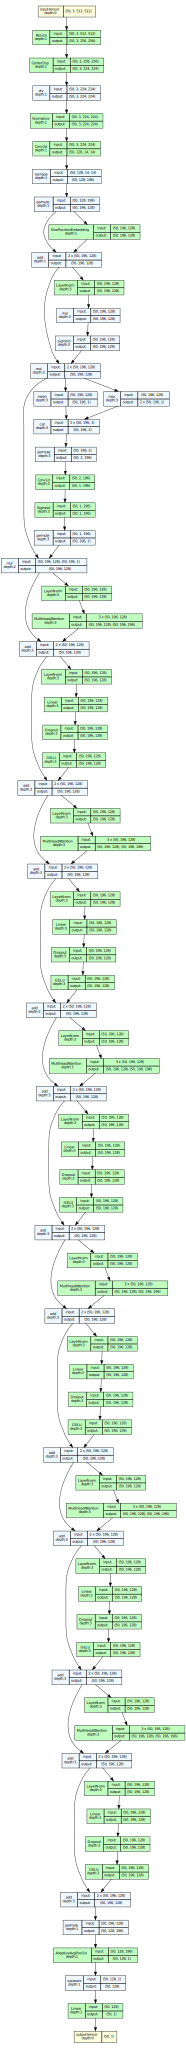

In [24]:
model_graph = draw_graph(vit_net, input_size=batch[0].shape,
                            hide_inner_tensors=True, hide_module_functions=True,
                            expand_nested=False, depth=3)
model_graph.visual_graph

In [31]:
s3 = boto3.client('s3')
model_filename = f"{N}_{VAL_SPLIT}_vit_nam_model_weights.pth"
model_key = 'checkpoints/vit_nam_model_weights.pth'

download_path = '/tmp/vit_nam_model_weights.pth'
s3.download_file(BUCKET_NAME, model_key, download_path)
print(f"✅ Downloaded model weight file: {model_key} from s3!")

✅ Downloaded model weight file: checkpoints/vit_nam_model_weights.pth from s3!


In [32]:
checkpoint = torch.load(download_path)
checkpoint['linear.weight'] = checkpoint['linear.weight'][:1, :]
checkpoint['linear.bias'] = checkpoint['linear.bias'][:1]
vit_net.load_state_dict(checkpoint)
vit_net.eval()

ViTNetwork(
  (network_metrics): ModuleDict(
    (acc): BinaryAccuracy()
  )
  (network_loss): BCEWithLogitsLoss()
  (patches): Conv2d(3, 128, kernel_size=(16, 16), stride=(16, 16), bias=False)
  (position_embedding): SinePositionEmbedding()
  (att): NAM(
    (channel_att): Channel_Att(
      (bn): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (spatial_att): Spatial_Att(
      (conv1d): Conv1d(2, 1, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (sigmoid): Sigmoid()
    )
  )
  (transformer_blocks): Sequential(
    (0): TransformerBlock(
      (layer_norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (layer_norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (activation): GELU(approximate='none')
      (linear): Linear(in_features=128, out_features=128, bias=True)
      (mha): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_featu

In [33]:
logger = pl.loggers.CSVLogger("logs",
                              name="term",
                              version="PTViT_NAM")

In [34]:
trainer = pl.Trainer(logger=logger,
                     max_epochs=MAX_EPOCHS,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=True,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [35]:
trainer.validate(vit_net, data_module)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/lightning_fabric/loggers/csv_logs.py:268: Experiment logs directory logs/term/PTViT_NAM exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!


Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.22499999403953552    │
│         val_loss          │    3.6133768558502197     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.22499999403953552, 'val_loss': 3.6133768558502197}]

In [36]:
start_time = time.time()

trainer.fit(vit_net, data_module)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time:.2f} seconds")

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory logs/term/PTViT_NAM/checkpoints exists and is not empty.

  | Name               | Type                  | Params | Mode
--------------------------------------------------------------------
0 | network_metrics    | ModuleDict            | 0      | eval
1 | network_loss       | BCEWithLogitsLoss     | 0      | eval
2 | patches            | Conv2d                | 98.3 K | eval
3 | position_embedding | SinePositionEmbedding | 0      | eval
4 | att                | NAM                   | 262    | eval
5 | transformer_blocks | Sequential            | 498 K  | eval
6 | pooling            | AdaptiveAvgPool1d     | 0      | eval
7 | linear             | Linear                | 129    | eval
--------------------------------------------------------------------
597 K     Trainable params
0         Non-trainable params
597 K     Total params
2.389     Total

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [37]:
trainer.validate(vit_net, data_module)

Validation: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.9549999833106995     │
│         val_loss          │    0.20619577169418335    │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.9549999833106995, 'val_loss': 0.20619577169418335}]

In [38]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")

NameError: name 'io' is not defined

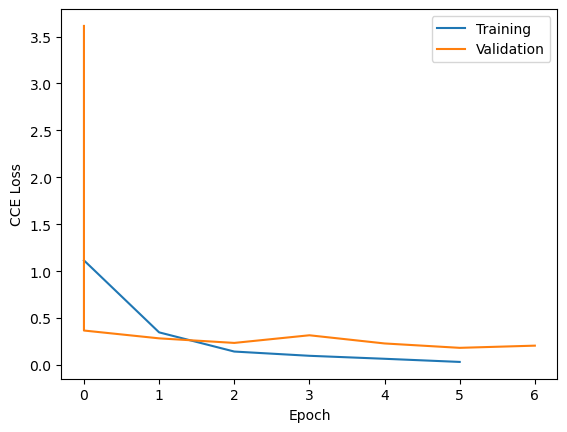

In [39]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))],
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))],
         label="Validation")
plt.legend()
plt.ylabel("CCE Loss")
plt.xlabel("Epoch")

# convert img to PNG
img_buffer = io.BytesIO()
plt.savefig(img_buffer, format="png")
img_buffer.seek(0)

# Upload to s3
curr_time_str = datetime.now().strftime('%Y%m%d%H%M%S')
s3 = boto3.client('s3')
s3_key = f"results/{curr_time_str}_{N}_{VAL_SPLIT}_{MAX_EPOCHS}_loss_plot.png"

s3.upload_fileobj(img_buffer, BUCKET_NAME, s3_key)

print(f"✅ Upload image to S3: {s3_key}")

plt.show()

NameError: name 'io' is not defined

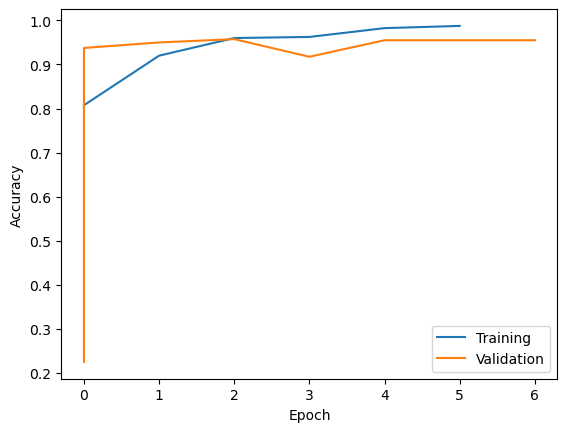

In [40]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_acc"]))],
         results["train_acc"][np.logical_not(np.isnan(results["train_acc"]))],
         label="Training")
plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_acc"]))],
         results["val_acc"][np.logical_not(np.isnan(results["val_acc"]))],
         label="Validation")
plt.legend()
plt.ylabel("Accuracy")
plt.xlabel("Epoch")

# convert img to PNG
img_buffer = io.BytesIO()
plt.savefig(img_buffer, format="png")
img_buffer.seek(0)

s3 = boto3.client('s3')
s3_key = f"results/{curr_time_str}_{N}_{VAL_SPLIT}_{MAX_EPOCHS}_acc_plot.png"

# Upload to s3
s3.upload_fileobj(img_buffer, BUCKET_NAME, s3_key)

print(f"✅ Upload image to S3: {s3_key}")
plt.show()